# Machine Learning II: Assignments 2
Leon Berghoff, Jiawei Li, Strahinja Trenkic, Otto Riess

In [1]:
import numpy as np
import pandas as pd
from bank_mkt import import_dataset, split_dataset, transform, evaluate, search
from sklearn.preprocessing import FunctionTransformer, StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_curve, precision_recall_curve
from sklearn.utils.fixes import loguniform
import matplotlib.pyplot as plt
import seaborn as sns
# cosmetic options
from IPython.display import set_matplotlib_formats
set_matplotlib_formats("svg")
rc = {"figure.figsize": (6.4, 4.8),
      "figure.dpi": 300,
      "axes.titlesize": "large",
      "axes.titleweight": "bold",
      "axes.titlepad": 12,
      "axes.titlelocation": "left"}
sns.set_theme(context="notebook", style="darkgrid", color_codes=True, rc=rc)

# Data Preparation

The bank marketing dataset was collected by Moro, Cortez, and Rita (2014) with marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be or not subscribed. The data is ordered by date ranging from May 2008 to November 2010.

To get a better feeling of some of the features, we can group them in 4 categories and provide a quick overview:

1. Last Contact Data
  * Duration of Contact
  * Method of Contact
  * Time of Contact
2. Social and Economic Context
  * Euribor Rate
  * Consumer Confidence
  * Consumer Price Index (Inflation)
3. Other attributes
  * Outcome of Previous Campaign
  * Number of Contacts

In [2]:
bank_mkt = import_dataset("BankMarketing.csv")

In [3]:

func_transformer = FunctionTransformer(transform)

num_features = ["month",
                "day_of_week",
                "campaign",
                "previous",
                "emp.var.rate",
                "cons.price.idx",
                "cons.conf.idx",
                "euribor3m",
                "nr.employed"]

standard_scaler = ColumnTransformer([("scaler", StandardScaler(), num_features)], remainder="passthrough")

preprocessor = make_pipeline(func_transformer, standard_scaler)

X_train, y_train, X_test, y_test, *_ = split_dataset(bank_mkt, preprocessor, test_size=0.3)

# Metrics

The dataset is clearly imbalanced where positive results are far less than negative results. Banks want to improve both recall and precision rates for marketing compains while the true negative rate is not as important.Unlike standard evaluation metrics that treat all classes as equally important, imbalanced classification problems typically rate classification errors with the minority class as more important than those with the majority class. As such performance metrics may be needed that focus on the minority class, which is made challenging because it is the minority class where we lack observations required to train an effective model.

In [4]:
np.unique(y_train, return_counts=True)

(array([0, 1]), array([7136, 2309]))

Average precision (AP) summarizes such a plot as the weighted mean of precisions achieved at each threshold, with the increase in recall from the previous threshold used as the weight.

$$
AP = \sum_{n} (REC_n - REC_{n-1})PRE_n
$$

A receiver operating characteristic (ROC) is a graphical plot which illustrates the performance of a binary classifier system as its discrimination threshold is varied. It is created by plotting TPR against FPR at various threshold settings. The false positive rate (FPR) and true positive rate (TPR) are defined as follows:

$$ TPR = \frac{TP}{TP+FN} $$

$$ FPR = \frac{FP}{FP+TN} $$

A diagonal line from bottom left to top right would represent a classifier that cannot classify better than a random guess. A perfect classifier would be one located in the top left corner where there are no False Positives. A classifier that "guesses" worse than a coin flip would be located below this diagonal line.

Both metrics work well with imbalaced dataset while AP sets higher weights for true positives.


In [5]:
names = ["Constant Prediction",
         "Random Prediction",
         "K-Nearest Neighbors",
         "Linear SVM",
         "Decision Tree",
         "Logistic Regression"]

clfs = [DummyClassifier(strategy="constant", constant=1),
        DummyClassifier(strategy="uniform"),
        KNeighborsClassifier(n_neighbors=10),
        SGDClassifier(loss="hinge", class_weight="balanced"),
        DecisionTreeClassifier(max_depth=5, class_weight="balanced"),
        LogisticRegression(class_weight="balanced")]

n = len(names)

y_pred = {}
for name, clf in zip(names, clfs):
    y_pred[name] = cross_val_predict(clf, X_train, y_train, cv=5, n_jobs=-1)

y_score = {}

y_threshold = {}

for name, clf in zip(names, clfs):
    if hasattr(clf, "decision_function"):
        response_method = "decision_function"
    else:
        response_method = "predict_proba"
        
    y_score[name] = cross_val_predict(clf,
                                      X_train,
                                      y_train,
                                      cv=5,
                                      n_jobs=-1,
                                      method=response_method)
    
    if name == "Logistic Regression":
        # For logistic regression, the hyperplane refered in the decision function is b_0+b_1x_1+...b_kx_k.
        # When hyperplane is 0, the probablity is 0.5,
        # therefore the threshold of decision function for logistic regression is 0.
        # https://stats.stackexchange.com/questions/329857/what-is-the-difference-between-decision-function-predict-proba-and-predict-fun
        y_threshold[name] = 0
    elif name == "Linear SVM":
        y_threshold[name] = 0
    else:
        y_score[name] = y_score[name][:, 1]
        y_threshold[name] = 0.5

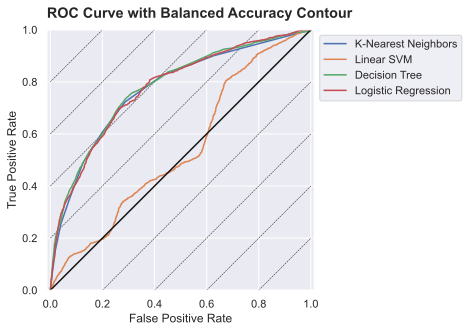

In [6]:
fig, ax = plt.subplots(figsize=(4.8, 4.8))

def bacc(x, y):
    return (1-x+y)/2

x = np.linspace(0,1,100)
y = np.linspace(0,1,100)
X, Y = np.meshgrid(x, y)
Z = bacc(X, Y)
ax.contour(X, Y, Z, levels=10, linewidths=0.5, linestyles="dashed", colors="k")

for name in names[2:]:
    fpr, tpr, thresholds = roc_curve(y_train, y_score[name])
    ax.plot(fpr, tpr, label=name)
    
ax.plot([0, 1], [0, 1], color="k")
ax.axis("equal")
ax.legend(bbox_to_anchor=(1, 1), loc='upper left')
ax.set(xlabel="False Positive Rate",
       ylabel="True Positive Rate",
       title="ROC Curve with Balanced Accuracy Contour");

From the figure above, we can see all algorithms except Linear SVM perform at the same level. Linear SVM performs the worst.

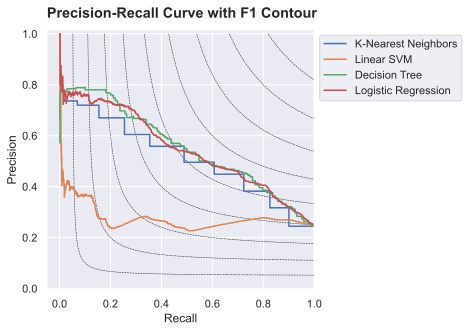

In [7]:
fig, ax = plt.subplots(figsize=(4.8, 4.8))

def f1(x, y):
    return 2*x*y/(x+y)

x = np.linspace(0.01,1)
y = np.linspace(0.01,1)
X, Y = np.meshgrid(x, y)
Z = f1(X, Y)
ax.contour(X, Y, Z, levels=10, linewidths=0.5, linestyles="dashed", colors="k")

for name in names[2:]:
    precisions, recalls, thresholds = precision_recall_curve(y_train, y_score[name])
    precisions = precisions[:-1]
    recalls = recalls[:-1]
    ax.plot(recalls, precisions, drawstyle="steps-post", label=name)

ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.axis("equal")
ax_legend = ax.legend(bbox_to_anchor=(1, 1), loc='upper left')
ax_set = ax.set(xlabel="Recall", ylabel="Precision", title="Precision-Recall Curve with F1 Contour")

From the figure above, we can see that Decision Tree and Logistic Regression perform the best. Linear SVM performs the worst.

# SVM

## Polynomial Kernel

The polinomial kernel is 

$$
K(x_i,x_j) = ( r + \gamma x_i^T x_j)^d
$$

where $d$ is degree of the polinomial kernel, $r$ is a constant and $\gamma$ is scaler.

Because kernel values usually depend on the inner products of feature vectors, e.g. the linear kernel and the polynomial kernel, large attribute values might cause numerical problems. The point being that unlike other conventional kernels the polinomial kernel rises exponentially with $d$. 

According to the research performed by Li-Chia Yeh and Chung-Chin Lu from Department of Electrical Engineering, National Tsing Hua University, the relationship between the error rate and these hyperpameters is as follows. Each curve represents a value of $d$:

![The relationship between the error rate and degrees](polin.jpg)

Usually the parameter $r$ is set to zero and $\gamma$ to a fixed value, e.g. 1/n with n being the number of observations. Beside the cost parameter $C$ the integer parameter $d$ has to be tuned, usually values between 1 and 10 are chosen.

In [8]:
poly_svm = SVC(kernel="poly", class_weight="balanced", max_iter=1e6, random_state=42)

poly_distributions = {
    "C": loguniform(1, 1e2),
    "gamma": loguniform(0.001, 1),
    "degree": range(2, 10),
    }

search(X_train, y_train, X_test, y_test, poly_svm, poly_distributions, scoring="average_precision")

best parameters found: {'C': 20.064823808353058, 'degree': 5, 'gamma': 0.00725890803300989}, with mean test score: 0.4382877489440751.


,Train,Test
TNR,0.793442,0.793656
TPR,0.372023,0.335354
REC,0.372023,0.335354
PRE,0.368195,0.344756
bACC,0.582732,0.564505
ROC,0.729430,0.716798
AP,0.416421,0.402713


In [9]:
poly_svm = SVC(kernel="poly", class_weight="balanced", max_iter=1e6, random_state=42)

poly_distributions = {
    "C": loguniform(1, 1e2),
    "gamma": loguniform(0.001, 1),
    "degree": range(2, 10),
    }

search(X_train, y_train, X_test, y_test, poly_svm, poly_distributions, scoring="roc_auc")

best parameters found: {'C': 42.15814768803568, 'degree': 4, 'gamma': 0.0021097212500602457}, with mean test score: 0.7282141165269099.


,Train,Test
TNR,0.828615,0.819817
TPR,0.562148,0.558586
REC,0.562148,0.558586
PRE,0.514875,0.500906
bACC,0.695382,0.689201
ROC,0.706182,0.706309
AP,0.412079,0.407904


We can see that optimizing for AP and ROC reaches to similiar but not the same results. The search using AP achieved better ROC and AP on the test set.

## Gaussian Kernels

The radial kernel function reads

$$K\left(X_{1}, X_{2}\right)=\exp \left(-\frac{\left\|X_{1}-X_{2}\right\|^{2}}{2 \sigma^{2}}\right)$$

where $\sigma$ is variance and our hyperparameter. The radial kernel is one of the most popular kernels. RBFs are able to avoid problems of space complexity, as they do not have to store the full dataset during training, but just the support vectors.

Given this simple kernel function, sci-kit learn RBF models only come with the SVM-wide cost hyperparameter $C$, as well as $γ$, which is inversely proportional  to  σ. Intuitively, the gamma parameter is the inverse of the radius of influence of support vectors. A large gamma thus increases the risk of overfitting. The cost hyperparameter essentially controls how much cost incurs for a misclassification for a given curve.

In [10]:
rbf_svm = SVC(kernel="rbf", class_weight="balanced", max_iter=1e6, random_state=42)

rbf_distributions = {
    "C": loguniform(1, 1e2),
    "gamma": loguniform(0.001, 1),
    }

search(X_train, y_train, X_test, y_test, poly_svm, rbf_distributions, scoring="average_precision")

best parameters found: {'C': 10.741709759448511, 'gamma': 0.0038023041625615366}, with mean test score: 0.4412128142558591.


,Train,Test
TNR,0.867152,0.860693
TPR,0.320918,0.309091
REC,0.320918,0.309091
PRE,0.438721,0.418033
bACC,0.594035,0.584892
ROC,0.726531,0.719841
AP,0.434226,0.416376


In [11]:
rbf_svm = SVC(kernel="rbf", class_weight="balanced", max_iter=1e6, random_state=42)

rbf_distributions = {
    "C": loguniform(1, 1e2),
    "gamma": loguniform(0.001, 1),
    }

search(X_train, y_train, X_test, y_test, poly_svm, rbf_distributions, scoring="roc_auc")

best parameters found: {'C': 1.1035701059802179, 'gamma': 0.001718541315988796}, with mean test score: 0.7310994656609234.


,Train,Test
TNR,0.802410,0.790713
TPR,0.602858,0.597980
REC,0.602858,0.597980
PRE,0.496788,0.480519
bACC,0.702634,0.694346
ROC,0.728986,0.723914
AP,0.427073,0.412976


RBF kernel searching using ROC reaches the better result on test set. However, the improvement of using RBF kernel over polynomial kernel is very minimal.

# Conclusions

As with all Machine Learning applications there are very problem specific differences that make proposing rules that apply to all applications more dangerous than useful.

* Picking an evaluation metric is a crucial part of any project. This becomes additionally difficult in unbalanced datasets where the standard metrics can be even missleading in measuring the model performance.
* The choice of the kernel and kernel parameters can be automated by optimising a cross-valdiation based model selection.
* Automated choice of kernels and kernel parameters is a tricky issue, as it is very easy to overfit the model selection criterion (typically cross-validation based), and you can end up with a worse model than you started with.
* There is a trade-off between kernel complexity and computing time needed to tune the kernel (polynomial vs RBF).